# Illustrations of Phonlab library

In [49]:
import os
import sys
import matplotlib.pyplot as plt
import librosa
import numpy as np
import seaborn as sns
import parselmouth
from IPython.display import Audio
import importlib

cwd = os.getcwd()
sys.path.insert(0, os.path.abspath(os.path.dirname(cwd)))

import phonlab as phon

importlib.reload(phon)

print(phon.__name__,phon.__version__)

phonlab 0.0.18


In [50]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'stereo.wav'

# --------
ret = phon.loadsig(example_file)  # taking just the left channel
fs_orig = ret.pop()
x = ret[0]

# or you can say 

*chans, fs_orig = phon.loadsig(example_file)
x = chans[0]

# or you can say 

#x, fs_orig = phon.loadsig(example_file, chansel=[0])

# --------

y,fs = phon.prep_audio(x,fs_orig,outtype='int')
print(np.max(y))

y,fs = phon.prep_audio(x,fs_orig,outtype='float')
print(np.max(y))

Resampling from 48000 to 22050
32439
Resampling from 48000 to 22050
0.99


regular smoothing factor = 11.030, robust smoothing factor = 1.826


Text(0.5, 1.0, 'Robust Smoothing')

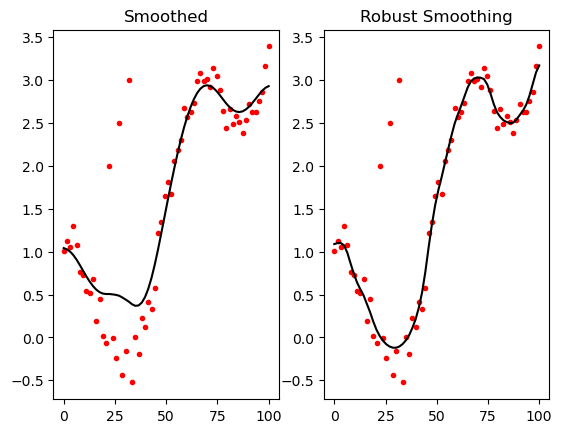

In [115]:
# 1-D example
x = np.linspace(0,100,2**6);
y = np.cos(x/10)+(x/50)**2 + np.random.random_sample(len(x))/2;
y[[14, 17, 20]] = [2, 2.5, 3];

z,s,e = phon.smoothn(y); # Regular smoothing
zr,sr,e = phon.smoothn(y,isrobust=True); # Robust smoothing

print(f'regular smoothing factor = {s:.3f}, robust smoothing factor = {sr:.3f}')

plt.subplot(121), 
plt.plot(x,y,'r.')
plt.plot(x,z,'k')
plt.title("Smoothed")

plt.subplot(122)
plt.plot(x,y,'r.')
plt.plot(x,zr,'k')
plt.title("Robust Smoothing")


## phon.track_formants()

Python native code implements both LPC and Inverse Filter Control (IFC) vowel formant tracking. 

IFC doesn't care if the waveform format is float or int

LPC_tracking(), with order set to -1, and pitch range [60, 350]
Resampling from 16000 to 12000
Selected LPC order is: 10


sec        rms           F1           F2           F3           F4  \
0  0.01 -61.888317  1400.480594  2833.892559  3702.328739  4870.584998   
1  0.02 -64.385788  1276.610974  2825.008675  6000.000000          NaN   
2  0.03 -65.342529  1338.200868  2340.685017  3592.929620  4665.434419   
3  0.04 -62.207226  1720.165390  2988.779912  6000.000000          NaN   
4  0.05 -60.010612  2210.393297  4565.262584  6000.000000          NaN   

           f0         c  
0   89.552239  0.299366  
1  173.913043  0.296322  
2  108.108108  0.348387  
3  300.000000  0.349103  
4  285.714286  0.390971

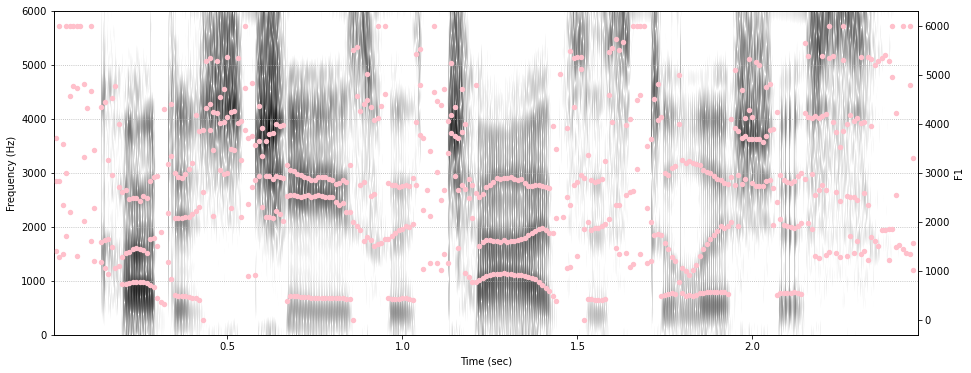

In [83]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'sf3_cln.wav'
test_file = "s09003.wav"
x,fs = phon.loadsig(example_file, chansel=[0])
fmtsdf = phon.track_formants(x, fs, f0_range=[60,350])

ret = phon.sgram(x,fs, cmap="Grays",tf=6000)  # plot the spectrogram
ax1 = ret[0].twinx()

dot_color = "pink"
sns.pointplot(fmtsdf,x='sec',y='F1',linestyle='none',native_scale=True,marker=".",
              color=dot_color, ax=ax1)
sns.pointplot(fmtsdf,x='sec',y='F2',linestyle='none',native_scale=True,marker=".",
              color=dot_color,ax=ax1)
sns.pointplot(fmtsdf,x='sec',y='F3',linestyle='none',native_scale=True,marker=".",
              color=dot_color,ax=ax1)
fmtsdf.head()

## phon.sgram()

Makes a pretty good looking spectrogram

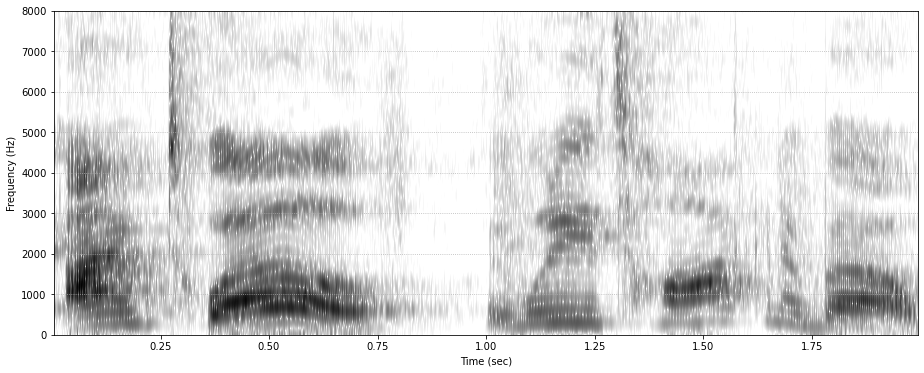

In [4]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'stereo.wav'

x,fs = phon.loadsig(example_file, chansel=[0])
phon.sgram(x,fs)

#Audio(example_file)
Audio(x,rate=fs)

(60.0, 360.0)

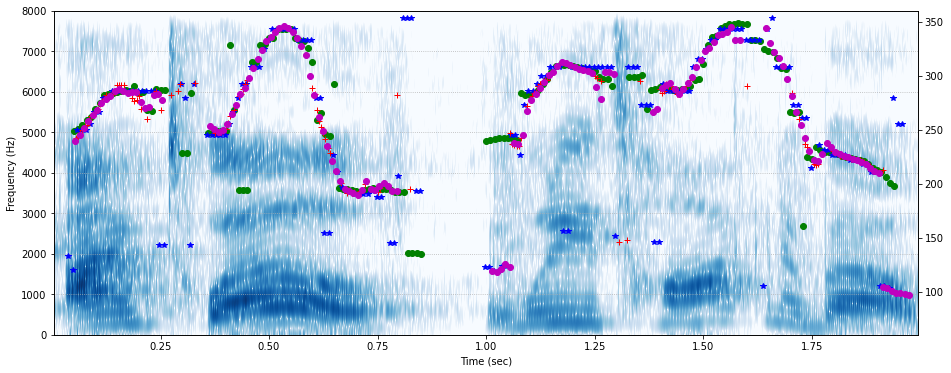

In [5]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'stereo.wav'

x,fs = phon.loadsig(example_file, chansel=[0], rate = 16000)

ret = phon.sgram(x,fs,cmap='Blues') # draw a spectrogram of the sound
ax1 = ret[0]  # get the plot axis
ax2 = ax1.twinx()  # and twin it for plotting f0

f0df1 = phon.get_f0_srh(x,fs,f0_range=[100,360])
f0df2 = phon.get_f0(x,fs,f0_range=[100,360])
f0df3 = phon.get_f0_acd(x,fs,prom=12)

snd = parselmouth.Sound(str(example_file)).extract_left_channel()  # create a Praat Sound object
pitch = snd.to_pitch()  # create a Praat pitch object
f0df4 = phon.pitch2df(pitch)  # convert it into a Pandas dataframe


lband, fs_diff = phon.amplitude_envelope(x,fs,bounds=[120,3000],target_fs=12000)
hband, fs_diff = phon.amplitude_envelope(x,fs,bounds=[3000,5999],target_fs=12000)
diff = lband-hband  # the difference in the low and high envelopes
f0df1["vocalic"] = diff[(f0df1['sec']*fs_diff).astype(int)]>0.01  # add 'vocalic' to the dataframe
f0df1.loc[f0df1["vocalic"] == False, "f0"] = np.nan # ignore nonvocalic formants
f0df2["vocalic"] = diff[(f0df2['sec']*fs_diff).astype(int)]>0.01  # add 'vocalic' to the dataframe
f0df2.loc[f0df2["vocalic"] == False, "f0"] = np.nan # ignore nonvocalic formants


ax2.plot(f0df1.sec,f0df1.f0, 'go')  
ax2.plot(f0df2.sec,f0df2.f0, 'b*')  
ax2.plot(f0df3.sec,f0df3.f0, 'r+')  
ax2.plot(f0df4.sec,f0df4.f0, 'mo')

ax2.set_ylim(60,360)


### phon.formant2df

One of the **Tidypraat** routines working with parselmouth to call Praat functions in python

sec          F1           F2           F3           F4
0  0.027187  689.351534  1278.692293  2368.521702  3827.620563
1  0.033437  854.791914  1281.970660  2523.518197  3770.162907
2  0.039687  904.327993  1281.020271  2579.691875  3773.183307
3  0.045937  948.427004  1298.713749  2555.204348  3777.036536
4  0.052187  939.872437  1323.038408  2472.017624  3748.192314

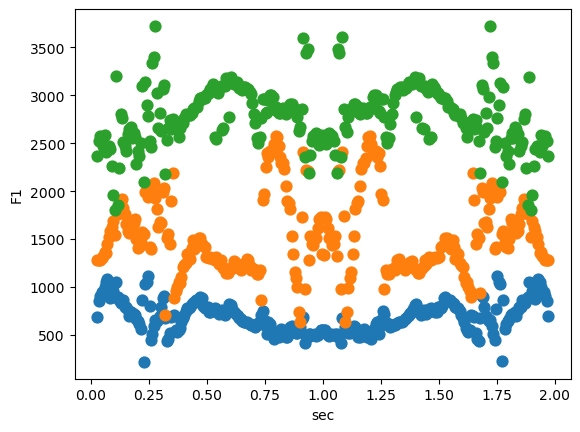

In [6]:
snd = parselmouth.Sound(str(example_file))  # create a Praat Sound object
maxf = 5500       # use 5000 for men, 6000 for women, 8000 for children
fmnt = snd.to_formant_burg(maximum_formant=maxf)  # create a Praat Formant object
fmntdf = phon.formant2df(fmnt, 4, include_bw=False)  # convert it into a Pandas dataframe

sns.pointplot(fmntdf,x='sec',y='F1',linestyle='none',native_scale=True)
sns.pointplot(fmntdf,x='sec',y='F2',linestyle='none',native_scale=True)
sns.pointplot(fmntdf,x='sec',y='F3',linestyle='none',native_scale=True)

fmntdf.head()

## phon.amplitude_envelope()

Here's an intersting application of one of the phonab functions.  Get the amplitude envelope in a low frequency band, and then in a high frequency band.  The difference between them (plotted in red over the spectrogram below) segments the speech into consonant and vowel regions.  Above zero is 'vocalic' and below zero is 'consonantal'.

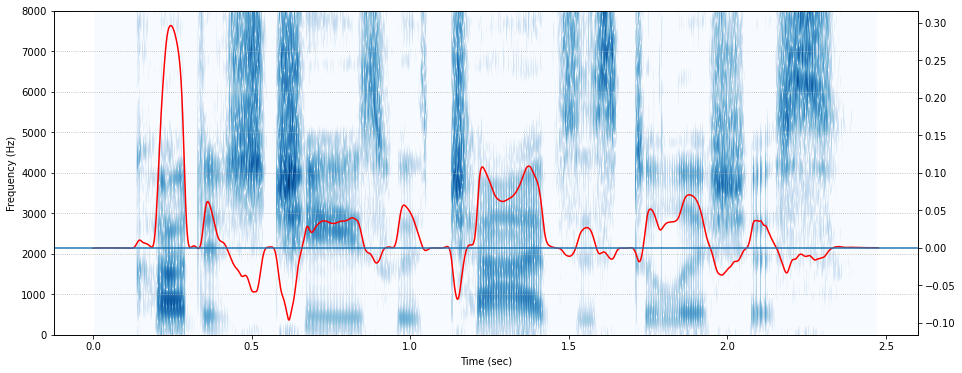

In [7]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'sf3_cln.wav'

x,fs = phon.loadsig(example_file, chansel=[0])
y=np.copy(x)

lband, fs_diff = phon.amplitude_envelope(y,fs,bounds=[120,3000],target_fs=12000)
hband, fs_diff = phon.amplitude_envelope(y,fs,bounds=[3000,5999],target_fs=12000)

diff = lband-hband  # the difference in the low and high envelopes
time_axis = np.arange(len(diff))/fs_diff  # a time axis for envelope plotting

ax1,f,t,Sxx = phon.sgram(x,fs,cmap='Blues') # draw the spectrogram from the array of samples

ax2 = ax1.twinx()
ax2.plot(time_axis,diff, color = "red")  # add scaled diff function
ax2.axhline(0) 

Audio(example_file)

### Vocalic

This code block uses the diff[] array plotted above to define a **vocalic** feature, 
and then uses that feature to clean up the formant plot.  This is really only needed for 
nice looking graphs.  Illustrating here the three main formant tracking algorithms.

IFC_tracking(), using method ifc, with speaker set to 2, and pitch range [63, 400]
Resampling from 16000 to 12000
 done         


<Axes: xlabel='Time (sec)', ylabel='Frequency (Hz)'>

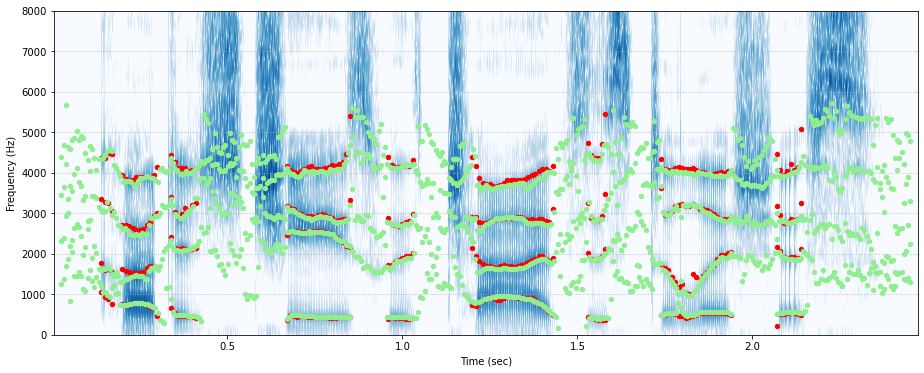

In [8]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'sf3_cln.wav'

# 1) IFC formant tracking
x,fs = phon.loadsig(example_file, chansel=[0])

# 2) Python native LPC formant tracking
fmtsdf = phon.track_formants(x,fs,method='ifc',order = 10, speaker=2)

# 3) Praat LPC formant tracking
snd = parselmouth.Sound(str(example_file))  # create a Praat Sound object
maxf = 6000       # use 5000 for men, 6000 for women, 8000 for children
fmnt = snd.to_formant_burg(maximum_formant=maxf)  # create a Praat Formant object
fmtdf = phon.formant2df(fmnt, 4, include_bw=False)  # convert it into a Pandas dataframe

# ------ use "vocalic" to decide which formant measurements to draw --------  # note pre=0 is important here
lband, fs_diff = phon.amplitude_envelope(x,fs,bounds=[120,3000],target_fs=12000)
hband, fs_diff = phon.amplitude_envelope(x,fs,bounds=[3000,5999],target_fs=12000)
diff = lband-hband  # the difference in the low and high envelopes
fmtsdf["vocalic"] = diff[(fmtsdf['sec']*fs_diff).astype(int)]>0.005  # add 'vocalic' to the dataframe
fmtsdf.loc[fmtsdf["vocalic"] == False, ("F1","F2","F3","F4")] = np.nan # ignore nonvocalic formants

phon.sgram(x,fs, cmap="Blues")  # plot the spectrogram

# add formant dots to the spectrogram
dot_color = "red"
sns.pointplot(fmtsdf,x='sec',y='F1',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F2',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F3',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtsdf,x='sec',y='F4',linestyle='none',native_scale=True,marker=".",color=dot_color)

dot_color = "lightgreen"
sns.pointplot(fmtdf,x='sec',y='F1',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtdf,x='sec',y='F2',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtdf,x='sec',y='F3',linestyle='none',native_scale=True,marker=".",color=dot_color)
sns.pointplot(fmtdf,x='sec',y='F4',linestyle='none',native_scale=True,marker=".",color=dot_color)

## phon.fricative()

Implements both major peak analysis and moments analysis.  The spectrum at time 0.635 (the 'ch' in 'cheese') illustrates that the "major peak" is the first well separated peak, not the point of maximum amplitude in the spectrum.

first major peak at 1600.0, Center of Gravity is 2698.3


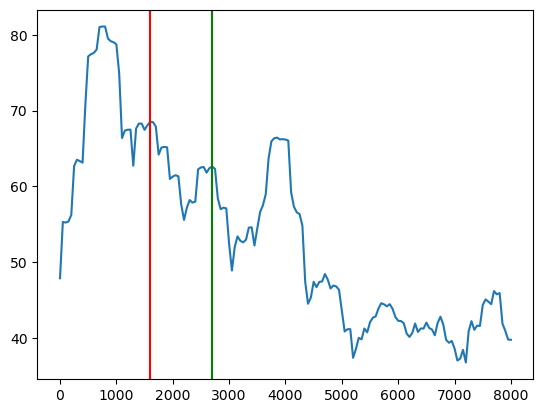

In [9]:
x,fs = phon.loadsig(example_file, chansel=[0], rate=None)
x,fs = phon.prep_audio(x,fs, pre=1, target_fs=16000, outtype = 'int')

Fm,FmB,Am,mode,COG,SD,Skew,Kurtosis,spec,freq = phon.fricative(x,fs,0.27)

print(f"first major peak at {Fm:.1f}, Center of Gravity is {COG:.1f}")
plt.plot(freq,spec)
plt.axvline(Fm,color="red")
plt.axvline(COG,color="green")

## phon.burst()

Resampling from 48000 to 22050
the stop release burst is at time: 0.269 seconds


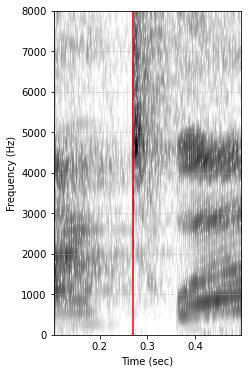

In [10]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'im_twelve.wav'

x,fs = phon.loadsig(example_file, chansel=[0])  
x,fs = phon.prep_audio(x,fs, pre=0.94) # add preemphasis, resample to 22050, ensure correct polarity, and scale to use maximum range

t1 = 0.1
t2 = 0.5

b_time, b_score = phon.burst(x,fs, t1,t2)  # find a stop burst in the span from t1 to t2
print(f"the stop release burst is at time: {b_time:.3f} seconds")
 
ax1,f,t,Sxx = phon.sgram(x,fs,start=t1, end=t2)
ax1.axvline(b_time,color="red")


## phon.egg_to_oq()

With a stereo audio file having audio in the left (channel 0) and electroglottography in the right (channel 1),
this function returns a time axis, f0, and open quotient.


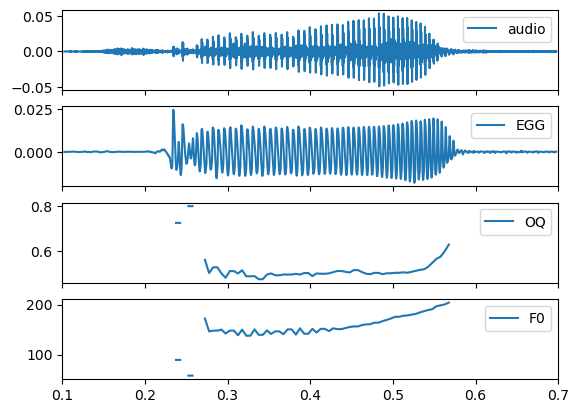

In [11]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'F1_bha24_1.wav'

egg,audio,fs = phon.loadsig(example_file, chansel=[1,0])  
oqdf = phon.egg_to_oq(egg,fs)  # return open quotient data

# ------ The rest of this example is making a nice plot ---------

time = [i/fs for i in range(audio.size)]  # the times of the audio samples.

start_time = 0.1
end_time = start_time + 0.6

sf = np.abs(oqdf.sec - start_time).argmin()  # closest frame to start_time
ef = np.abs(oqdf.sec - end_time).argmin()      # closest frame to end_time

si = int(oqdf.sec.iloc[sf]*fs)  # index of those frame times
ei = int(oqdf.sec.iloc[ef]*fs)    # in the audio and egg signals

fig = plt.figure()
ax1 =fig.add_subplot(411)
ax1.plot(time[si:ei],audio[si:ei],label="audio")
ax1.set_xlim(start_time,end_time)
ax1.set_xticklabels(([]))
ax1.legend()

ax2 =fig.add_subplot(412,sharex=ax1)
ax2.plot(time[si:ei],egg[si:ei],label="EGG")
ax2.legend()

ax3 =fig.add_subplot(413,sharex=ax1)
ax3.plot(oqdf.sec.iloc[sf:ef],oqdf.OQ.iloc[sf:ef],label="OQ")
ax3.legend()

ax4 =fig.add_subplot(414)
ax4.plot(oqdf.sec.iloc[sf:ef],oqdf.f0.iloc[sf:ef],label="F0")
ax4.set_xlim(start_time,end_time)
ax4.legend()


## phon.sine_synth()

With a formants data frame from phon.track_formants(), sine_synth() produces sine wave analogs of speech.

LPC_tracking(), with order set to -1, and pitch range [63, 400]
-8.429828
Selected LPC order is: 10


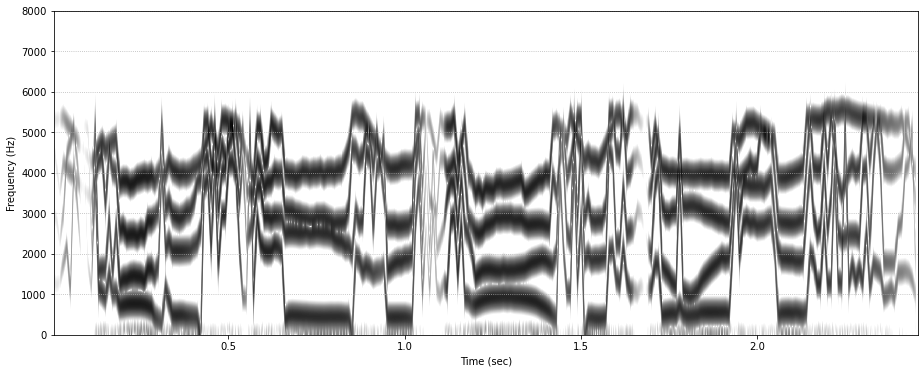

In [12]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'sf3_cln.wav'

x,fs = phon.loadsig(example_file,rate=12000)   # illustrating here that we can pass an array to track_formants()
fmtsdf = phon.track_formants(x,fs)    # track the formants

x2,fs2 = phon.sine_synth(fmtsdf)     # use the formants to produce sinewave synthesis
phon.sgram(x2,fs2, preemph=0)  # plot a spectrogram of it

Audio(x2,rate=fs2) 

## phon.sigcor_noise()

Replace signal with noise that matches the amplitude envelope of the signal

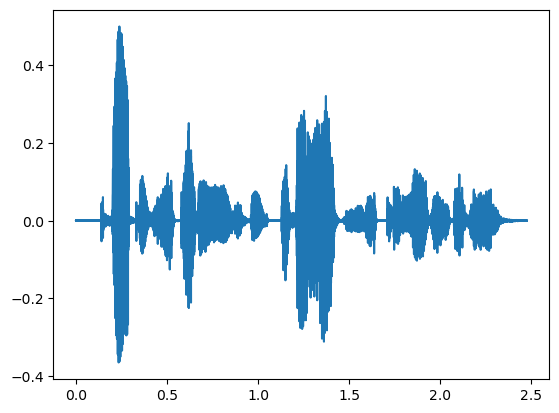

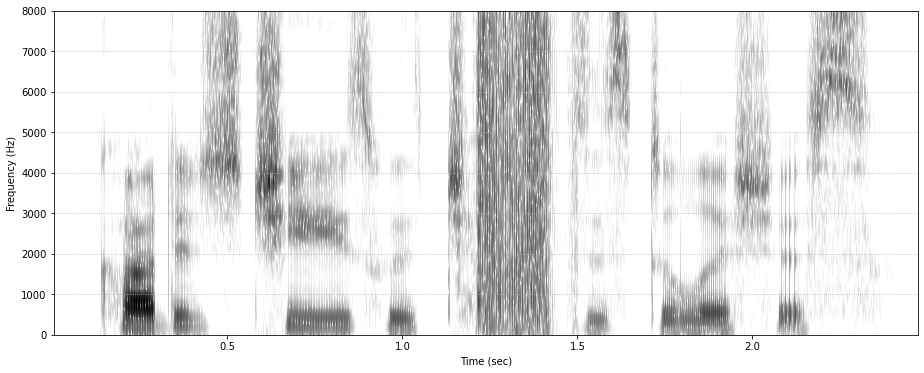

In [13]:
x,fs = phon.loadsig(example_file)   # illustrating here that we can pass an array to track_formants()
y,fs = phon.sigcor_noise(x,fs,flip_rate=0.4,start=1.2,end=1.5)

time_axis = np.arange(len(y))/fs
plt.plot(time_axis,y)  # add_noise pads the signal by 0.5 seconds

phon.sgram(y,fs,preemph=0)
Audio(y,rate=fs) 

## phon.add_noise()

A function that can be used to prepare speech in noise (SPIN) stimuli.


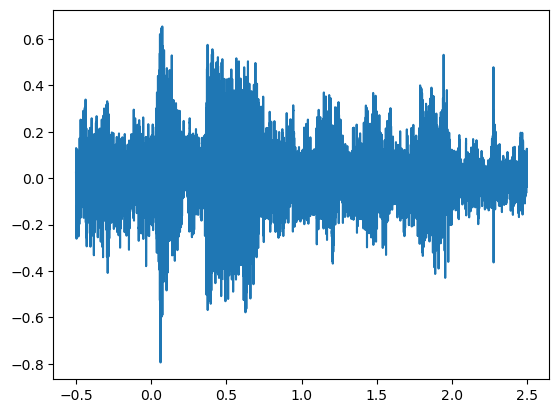

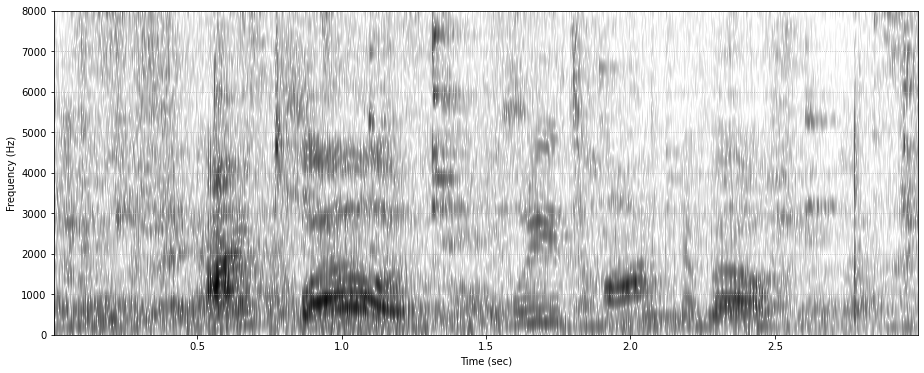

In [14]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'im_twelve.wav'

x,fs = phon.loadsig(example_file)   # illustrating here that we can pass an array to track_formants()
y,fs = phon.add_noise(x,fs,"restaurant",snr=3)
time_axis = np.arange(len(y))/fs

plt.plot(time_axis - 0.5,y)  # add_noise pads the signal by 0.5 seconds
y,fs = phon.prep_audio(y,fs,target_fs=None,pre=0)
phon.sgram(y,fs)
Audio(y,rate=fs) 

## phon.vocode()

Resynthesize speech with noise in frequency bands, simulating the amount of audio information in a cochlear implant.

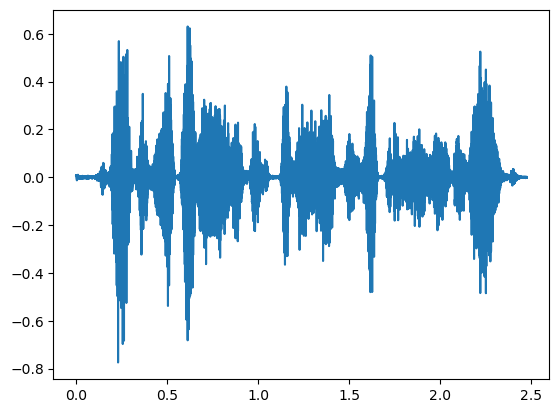

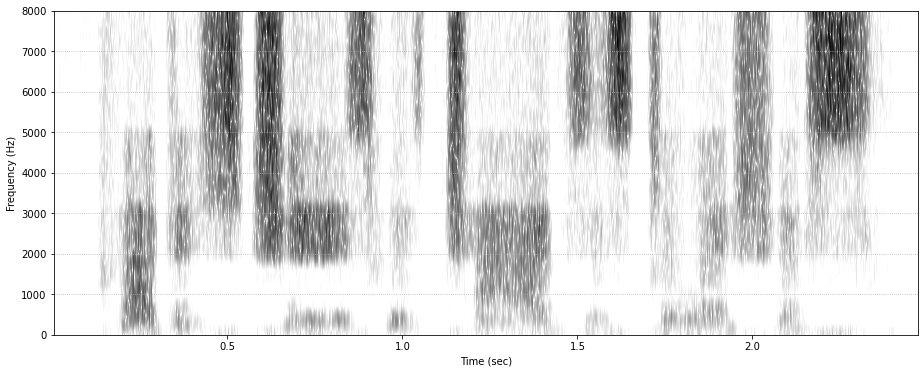

In [15]:
example_file = importlib.resources.files('phonlab') / 'data' / 'example_audio' / 'sf3_cln.wav'

bands_third = phon.third_octave_bands(high=8000)  # define filter bank
bands_shan = phon.shannon_bands(high=8000,nc=10)  # define filter bank

x,fs = phon.loadsig(example_file,rate=16000)   
y,fs = phon.vocode(x, fs, bands_shan)  # use one of the filter banks

time_axis = np.arange(len(y))/fs
plt.plot(time_axis,y)

phon.sgram(y,fs)

Audio(y,rate=fs) 